In [13]:
# coding: utf-8
#%matplotlib inline
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import timeit

import itertools
#from scipy.special import comb
#from scipy import stats

class Subsetselection:
    def __init__(self, absz, pri_para): # absz: alphabet size, pri_para: privacy parameter
        self.insz = absz #input alphabet size k
        self.exp = math.exp(pri_para)
        self.d = int(math.ceil(1.0*self.insz/(self.exp+1))) # number of 1s in output bit string 
        self.p = (1.0*self.d*self.exp)/(self.d*self.exp+self.insz-self.d)
        self.q = 1.0*(self.d-self.p)/(self.insz-1)
    def encode_symbol(self,ori):  # encode a single symbol into a privatized version
        sample = np.zeros(self.insz, dtype='bool')
        y_i = np.random.binomial(1,self.p)   
        if(y_i):
            sample[ori]=True
            temp = np.delete(np.array(range(self.insz)),ori, 0)
            temp2= np.random.choice(temp,self.d-1,replace=False)
            sample [temp2]= True
        else:
            sample[ori]=False
            temp = np.delete(np.array(range(self.insz)),ori, 0)
            temp2= np.random.choice(temp,self.d,replace=False)
            sample [temp2]= True
        return sample
    
    def encode_string_fast(self,in_list):  # encode string into a privatized string
        n = len(in_list)
        out_list = np.zeros((n, self.insz))
        flip = np.random.random_sample((n, self.insz))
        
        for i in range(n):
            out_list[i,in_list[i]] = np.logical_or(0,flip[i,in_list[i]] <self.p)
        return np.logical_or(out_list, flip < self.q)

    def encode_string_light(self,in_list):  # encode string into a privatized string
        n = len(in_list)
        counts = np.zeros(self.insz)
        time = 0
        for i in range(n):
            private_samples_subset = np.zeros(self.insz)
            flip = np.random.random_sample(self.insz)
            private_samples_subset[in_list[i]] = (flip[in_list[i]] < self.p)
            private_samples_subset = np.logical_or(private_samples_subset, flip < self.q)
            start_time = timeit.default_timer()
            counts = counts +  private_samples_subset
            time = time + timeit.default_timer() - start_time
            
        return counts, time
    
    def encode_string(self,in_list):  # encode string into a privatized string
        out_list = [self.encode_symbol(x) for x in in_list]
        return out_list
    
    def decode_string(self, out_list, length): # get the privatized string and learn the original distribution
        temp1 = ((self.insz-1)*self.exp+1.0*(self.insz-1)*(self.insz-self.d)/self.d) / ((self.insz-self.d)*(self.exp-1))
        temp2 = ((self.d-1)*self.exp+self.insz-self.d) / (1.0*(self.insz-self.d)*(self.exp-1))
        #print (np.sum(out_list, axis=0))
        p_estimate = (1.0*np.sum(out_list, axis=0)*temp1/length)-temp2
        p_estimate = np.maximum(p_estimate,0)
        norm = np.sum(p_estimate)
        p_estimate = p_estimate/float(norm)
        return p_estimate
        
    def decode_counts(self, counts, length): # get the privatized string and learn the original distribution
        temp1 = ((self.insz-1)*self.exp+1.0*(self.insz-1)*(self.insz-self.d)/self.d) / ((self.insz-self.d)*(self.exp-1))
        temp2 = ((self.d-1)*self.exp+self.insz-self.d) / (1.0*(self.insz-self.d)*(self.exp-1))
        #print (np.sum(out_list, axis=0))
        p_estimate = (1.0*counts*temp1/length)-temp2
        p_estimate = np.maximum(p_estimate,0)
        norm = np.sum(p_estimate)
        p_estimate = p_estimate/float(norm)
        return p_estimate

('l1 distance: ', '0.129957802041')
('prob_sum: ', '1.0')
1.65450048447


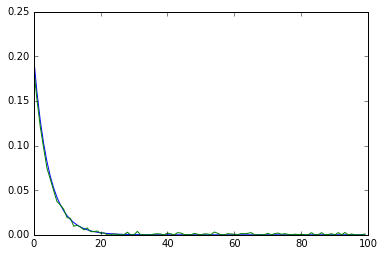

In [15]:
if __name__ == "__main__":    
    k = 100 #absz
    n= 1000000
    elements = range(0,k) #ab
    lbd = 0.8 #parameter for geometric dist
    eps = 1 # privacy_para
    prob = [(1-lbd)*math.pow(lbd,x)/(1-math.pow(lbd,k)) for x in elements] # geometric dist
    #prob = [1/float(k)] * k
    in_list = np.random.choice(elements, n, p=prob) #input symbols
    a = Subsetselection(k,eps) 
    #print (a.partsz)
    #print (elements.type)
    # print(type(in_list[9]))
    #outp = a.encode_string_fast(in_list)
    #prob_est = a.decode_string(outp,n) # estimate the original underlying distribution
    
    counts,time = a.encode_string_light(in_list)
    prob_est = a.decode_counts(counts, n)
    #print (counts)
    plt.plot(elements,prob)
    plt.plot(elements,prob_est)
    #plt.plot(prob_est)
    print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
    print ("prob_sum: ", str(sum(prob_est)))
    print (time)